In [1]:
pip install transformers torch pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv('truncated_labeled_data.csv')

# Display the first few rows to check the data
print(df.head())

                                                text  label
0  tech company bought another company late 22 wo...      0
1  im 7 months search ive definitely seen dark ho...      0
2  httpswwwcnncom20240222techattcellserviceoutage...      0
3  program created bring experts program heavily ...      0
4  field bring joy rather immense stress cycle la...      0


In [3]:
import re

# Simple text cleaning process
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces, tabs, and newlines
    return text

df['text'] = df['text'].apply(clean_text)

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

# Load tokenizers and models
bert_tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
bert_model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

roberta_tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
roberta_model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Function to get sentiment with truncation for BERT
def get_sentiment_bert(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Get the highest probability label
    label_idx = torch.argmax(outputs.logits, dim=1).item()
    labels = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']  # Modify as per model's label
    return labels[label_idx], torch.softmax(outputs.logits, dim=1).max().item()

# Function to get sentiment with truncation for RoBERTa
def get_sentiment_roberta(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    label_idx = torch.argmax(outputs.logits, dim=1).item()
    labels = ['Negative', 'Neutral', 'Positive']  # Modify as per model's label
    return labels[label_idx], torch.softmax(outputs.logits, dim=1).max().item()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [5]:
# Wrapper functions to simplify calling
def apply_sentiment_bert(text):
    label, score = get_sentiment_bert(text)
    return f"{label} {score:.4f}"

def apply_sentiment_roberta(text):
    label, score = get_sentiment_roberta(text)
    return f"{label} {score:.4f}"

# Apply sentiment analysis
df['bert_sentiment'] = df['text'].apply(apply_sentiment_bert)
df['roberta_sentiment'] = df['text'].apply(apply_sentiment_roberta)

# Print results to compare
print(df[['text', 'bert_sentiment', 'roberta_sentiment']].head())

                                                text  bert_sentiment  \
0  tech company bought another company late 22 wo...   1 star 0.6640   
1  im 7 months search ive definitely seen dark ho...  4 stars 0.2237   
2  httpswwwcnncom20240222techattcellserviceoutage...   1 star 0.7114   
3  program created bring experts program heavily ...   1 star 0.6570   
4  field bring joy rather immense stress cycle la...  2 stars 0.3235   

  roberta_sentiment  
0    Neutral 0.5356  
1    Neutral 0.5542  
2   Negative 0.7474  
3   Negative 0.6290  
4   Positive 0.7533  


In [6]:
# Print out results to compare
print(df[['text', 'bert_sentiment', 'roberta_sentiment']].head(20))


                                                 text  bert_sentiment  \
0   tech company bought another company late 22 wo...   1 star 0.6640   
1   im 7 months search ive definitely seen dark ho...  4 stars 0.2237   
2   httpswwwcnncom20240222techattcellserviceoutage...   1 star 0.7114   
3   program created bring experts program heavily ...   1 star 0.6570   
4   field bring joy rather immense stress cycle la...  2 stars 0.3235   
5   45 years old wife 2 kids house etc working 13 ...   1 star 0.4151   
6   started career used think 1 root companys reve...   1 star 0.3863   
7   lay leadership promote someone else company ta...  5 stars 0.3696   
8   seen many corporations lay people months hirin...   1 star 0.8221   
9                              repeat economy booming  5 stars 0.4319   
10  going 2008 type meltdown seems sub early warni...   1 star 0.5655   
11  im frustrated scared ive software engineer 17 ...   1 star 0.7768   
12  1 number company matter many years ive company.

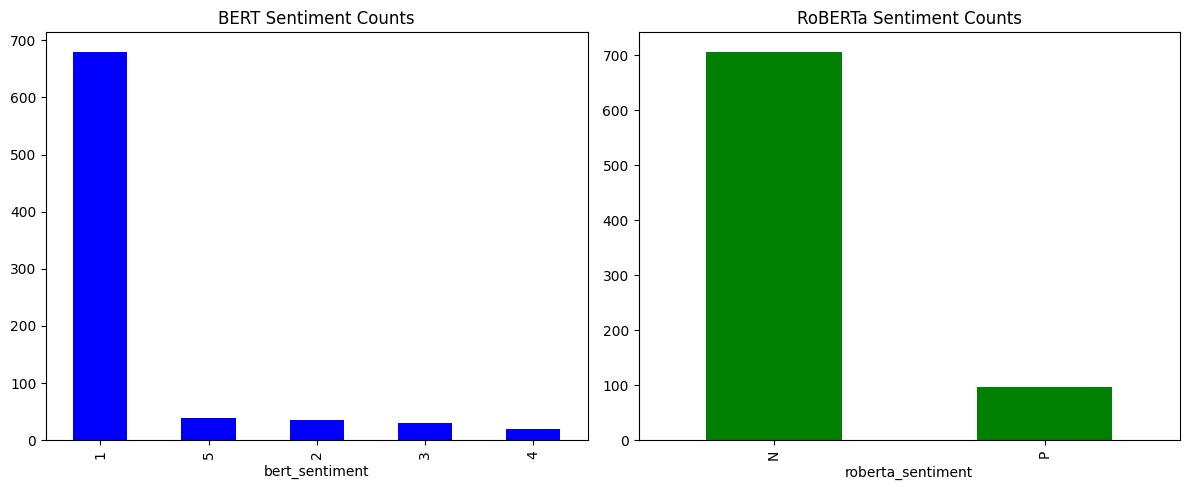

In [7]:
import matplotlib.pyplot as plt

# Assuming we're just plotting counts of sentiment labels for comparison
sentiment_bert_counts = df['bert_sentiment'].apply(lambda x: x[0]).value_counts()
sentiment_roberta_counts = df['roberta_sentiment'].apply(lambda x: x[0]).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sentiment_bert_counts.plot(kind='bar', ax=axes[0], title='BERT Sentiment Counts', color='blue')
sentiment_roberta_counts.plot(kind='bar', ax=axes[1], title='RoBERTa Sentiment Counts', color='green')

plt.tight_layout()
plt.show()